In [2]:
import pandas as pd

# โหลดไฟล์
sales_df = pd.read_csv("january_sales.csv")
promo_df = pd.read_excel("promotiom_1_2023.xlsx")

In [3]:
# Step 1: แปลงช่วงโปรโมชั่นให้เป็นราย item_id ต่อแถว

# แปลงวันที่ให้เป็น datetime
promo_df['promotion_start'] = pd.to_datetime(promo_df['promotion_start'])
promo_df['promotion_end'] = pd.to_datetime(promo_df['promotion_end'])

# แยก item_id ออกเป็น list แล้ว explode ให้เป็นรายแถว
promo_df['item_id'] = promo_df['item_id'].astype(str).str.split(',')
promo_exploded = promo_df.explode('item_id').reset_index(drop=True)

# แปลง item_id ให้เป็นตัวเลขเพื่อ match กับ sales_df
promo_exploded['item_id'] = promo_exploded['item_id'].astype(str).str.strip()
sales_df['item_id'] = sales_df['item_id'].astype(str).str.strip()

promo_exploded.head()


date_post promotion_start promotion_end  \
0 2023-01-01      2023-01-01    2023-01-01   
1 2023-01-01      2023-01-01    2023-01-01   
2 2023-01-01      2023-01-01    2023-01-01   
3 2023-01-01      2023-01-01    2023-01-01   
4 2023-01-01      2023-01-01    2023-01-01   

                             subcategory    item_id  
0  O-SUD KHUM VOUCHER,S-SUD KHUM VOUCHER  168929550  
1  O-SUD KHUM VOUCHER,S-SUD KHUM VOUCHER  168928695  
2  O-SUD KHUM VOUCHER,S-SUD KHUM VOUCHER  406347877  
3  O-SUD KHUM VOUCHER,S-SUD KHUM VOUCHER  406347641  
4  O-SUD KHUM VOUCHER,S-SUD KHUM VOUCHER  406347981

In [10]:
# Step 2: ตรวจสอบว่ายอดขายแต่ละวันอยู่ในช่วงโปรโมชั่นหรือไม่

# แปลงคอลัมน์ date ใน sales_df ให้เป็น datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# รวมข้อมูล: ใช้ merge แบบ many-to-many ตาม item_id
merged_df = sales_df.merge(promo_exploded, on='item_id', how='left')

# สร้างคอลัมน์ 'in_promo' โดยเช็คว่า date อยู่ในช่วง promotion_start ถึง promotion_end
merged_df['in_promo'] = (
    (merged_df['date'] >= merged_df['promotion_start']) &
    (merged_df['date'] <= merged_df['promotion_end'])
)

# แสดงผลลัพธ์ตัวอย่าง
# แสดงผลลัพธ์ตัวอย่างในเครื่องของคุณ
print(merged_df[['date', 'item_id', 'store_id', 'sales', 'units_sold', 'promotion_start', 'promotion_end', 'in_promo']].head(20))


         date    item_id  store_id      sales  units_sold promotion_start  \
0  2023-01-21       1899      6619   86.50000       0.432      2023-01-27   
1  2023-01-21   26455315      5505   64.50000       3.000             NaT   
2  2023-01-21   51954665      5018  393.22028       3.000             NaT   
3  2023-01-21   51178800      5018   63.00000       4.000             NaT   
4  2023-01-21    5874599      2450  109.35000       9.000             NaT   
5  2023-01-21    7588003      6619  145.80000       4.000             NaT   
6  2023-01-21   50485340      5018   29.90000       1.000             NaT   
7  2023-01-21  162532953      5032  396.23164       4.000             NaT   
8  2023-01-21   19391692      6490   24.68117       1.000             NaT   
9  2023-01-21   70651833      5018  580.42000      42.000             NaT   
10 2023-01-21   75100320      5035   73.83000       1.000      2023-01-18   
11 2023-01-21   52054450      6626   11.22000       1.000             NaT   

In [11]:
# กรองเฉพาะแถวที่ in_promo มีค่า True หรือ False (ไม่เอา NaN เพราะไม่มีข้อมูลโปร)
filtered_df = merged_df[merged_df['in_promo'].notna()].copy()

# คำนวณยอดขายเฉลี่ยและหน่วยขายเฉลี่ยช่วงมีโปรฯ และไม่มีโปรฯ
summary = filtered_df.groupby(['item_id', 'in_promo']).agg(
    avg_sales=('sales', 'mean'),
    avg_units_sold=('units_sold', 'mean'),
    total_days=('date', 'count')
).reset_index()

# Pivot ตารางเพื่อเทียบใน/นอกโปร
pivot = summary.pivot(index='item_id', columns='in_promo', values=['avg_sales', 'avg_units_sold', 'total_days'])
pivot.columns = ['avg_sales_no_promo', 'avg_sales_in_promo', 'avg_units_no_promo', 'avg_units_in_promo', 'days_no_promo', 'days_in_promo']
pivot = pivot.reset_index()

# เติมค่า NaN เป็น 0 สำหรับ item_id ที่อาจไม่มีช่วงใดช่วงหนึ่ง
pivot = pivot.fillna(0)

# แสดงผลลัพธ์
print(pivot.head(20))


     item_id  avg_sales_no_promo  avg_sales_in_promo  avg_units_no_promo  \
0    1000608          182.537609            0.000000            1.434783   
1    1000616          241.482057            0.000000            1.869231   
2    1007475           58.219440           63.624190            1.792208   
3    1012096           70.430729            0.000000            1.635417   
4    1012118           31.565376            0.000000            2.303303   
5    1012614          238.972149            0.000000            7.702290   
6   10169180          147.147286            0.000000            1.157143   
7   10169210          179.033407            0.000000            1.296703   
8   10171924          113.513043           99.370698            1.239130   
9   10174443          119.083293            0.000000            5.504286   
10  10174478           78.715000            0.000000            1.800000   
11   1017586           27.910960            0.000000            1.840909   
12   1020471

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1476313005.py:49: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1476313005.py:49: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1476313005.py:49: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1476313005.py:49: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1476313005.py:49: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1476313005.py:49: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing f

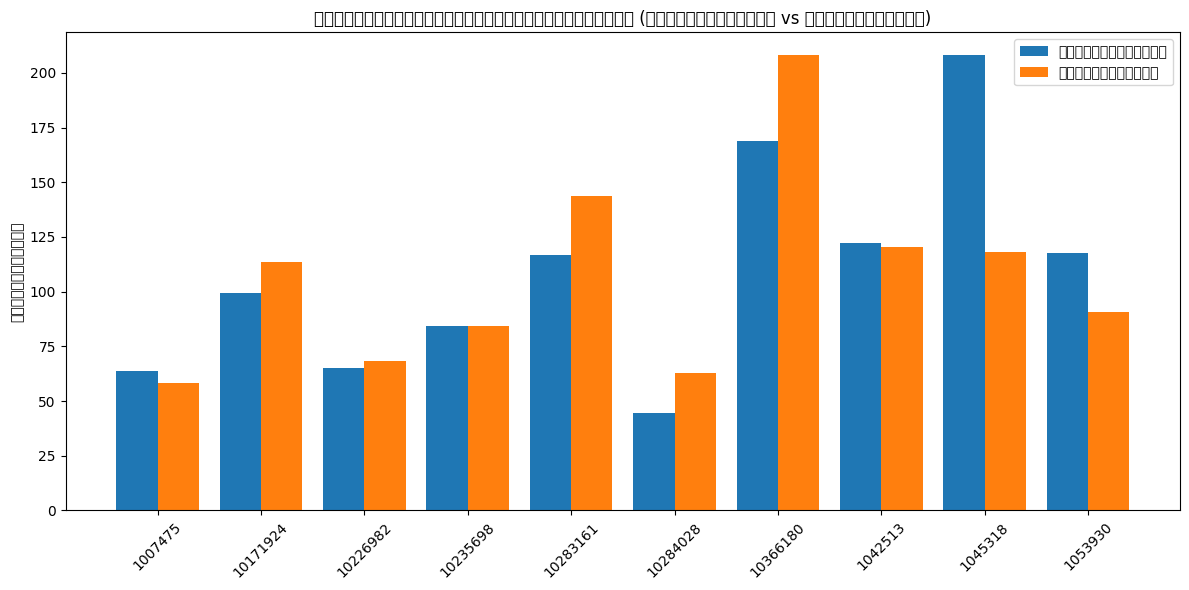

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# โหลดไฟล์
promo_df = pd.read_excel("promotiom_1_2023.xlsx")
sales_df = pd.read_csv("january_sales.csv")

# เตรียมข้อมูลโปรโมชั่น
promo_df['promotion_start'] = pd.to_datetime(promo_df['promotion_start'])
promo_df['promotion_end'] = pd.to_datetime(promo_df['promotion_end'])
promo_df['item_id'] = promo_df['item_id'].astype(str).str.split(',')
promo_exploded = promo_df.explode('item_id').reset_index(drop=True)
promo_exploded['item_id'] = promo_exploded['item_id'].astype(str).str.strip()

# เตรียมข้อมูลยอดขาย
sales_df['item_id'] = sales_df['item_id'].astype(str).str.strip()
sales_df['date'] = pd.to_datetime(sales_df['date'])

# รวมข้อมูล
merged_df = sales_df.merge(promo_exploded, on='item_id', how='left')
merged_df['in_promo'] = (
    (merged_df['date'] >= merged_df['promotion_start']) &
    (merged_df['date'] <= merged_df['promotion_end'])
)

# วิเคราะห์ผลกระทบ
filtered_df = merged_df[merged_df['in_promo'].notna()].copy()
summary = filtered_df.groupby(['item_id', 'in_promo']).agg(
    avg_sales=('sales', 'mean'),
    avg_units_sold=('units_sold', 'mean'),
    total_days=('date', 'count')
).reset_index()
pivot = summary.pivot(index='item_id', columns='in_promo', values=['avg_sales', 'avg_units_sold', 'total_days'])
pivot.columns = ['avg_sales_no_promo', 'avg_sales_in_promo', 'avg_units_no_promo', 'avg_units_in_promo', 'days_no_promo', 'days_in_promo']
pivot = pivot.reset_index().fillna(0)

# วาดกราฟเปรียบเทียบ
pivot_filtered = pivot[(pivot['avg_sales_in_promo'] > 0) & (pivot['avg_sales_no_promo'] > 0)].copy()
top_items = pivot_filtered.head(10)

plt.figure(figsize=(12, 6))
x = range(len(top_items))
plt.bar(x, top_items['avg_sales_in_promo'], width=0.4, label='ช่วงโปรโมชั่น', align='center')
plt.bar([i + 0.4 for i in x], top_items['avg_sales_no_promo'], width=0.4, label='นอกโปรโมชั่น', align='center')
plt.xticks([i + 0.2 for i in x], top_items['item_id'], rotation=45)
plt.ylabel("ยอดขายเฉลี่ย")
plt.title("เปรียบเทียบยอดขายเฉลี่ยของสินค้า (ช่วงโปรโมชั่น vs นอกโปรโมชั่น)")
plt.legend()
plt.tight_layout()
plt.show()



C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2816791449.py:14: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2816791449.py:14: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2816791449.py:14: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2816791449.py:14: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2816791449.py:14: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2816791449.py:14: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing f

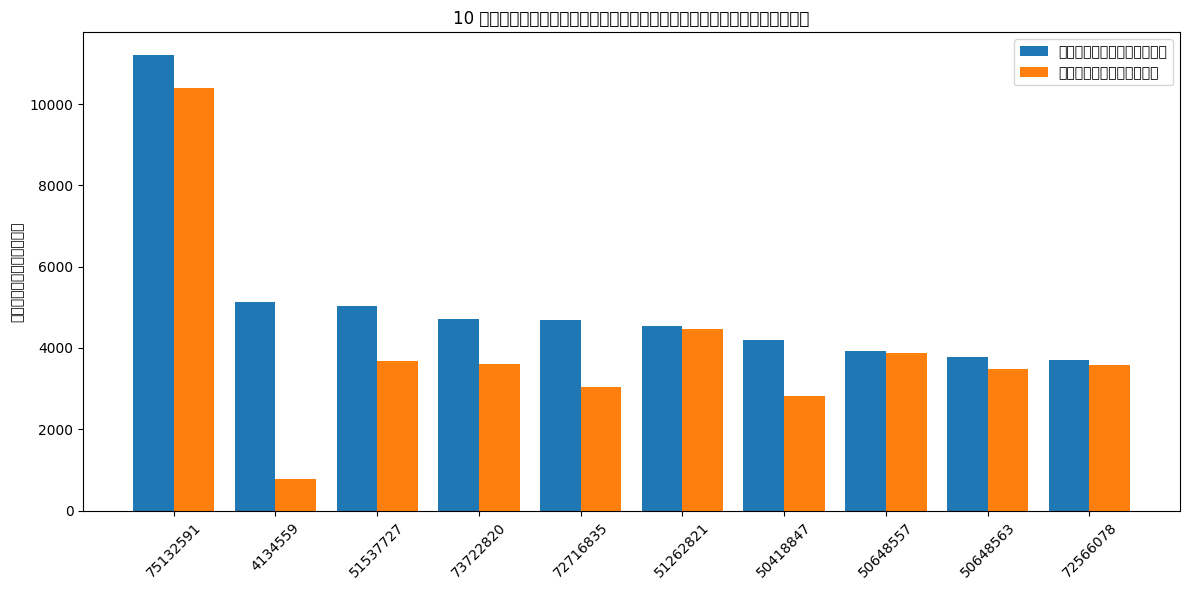

In [17]:
# กรองเฉพาะสินค้าที่ขายดีในช่วงโปรโมชั่น (ยอดขายเฉลี่ยสูงขึ้น)
top_promo_items = pivot[pivot['avg_sales_in_promo'] > pivot['avg_sales_no_promo']]
top_promo_items_sorted = top_promo_items.sort_values(by='avg_sales_in_promo', ascending=False).head(10)

# วาดกราฟเปรียบเทียบเฉพาะสินค้ากลุ่มนี้
plt.figure(figsize=(12, 6))
x = range(len(top_promo_items_sorted))
plt.bar(x, top_promo_items_sorted['avg_sales_in_promo'], width=0.4, label='ช่วงโปรโมชั่น', align='center')
plt.bar([i + 0.4 for i in x], top_promo_items_sorted['avg_sales_no_promo'], width=0.4, label='นอกโปรโมชั่น', align='center')
plt.xticks([i + 0.2 for i in x], top_promo_items_sorted['item_id'], rotation=45)
plt.ylabel("ยอดขายเฉลี่ย")
plt.title("10 สินค้าที่ขายดีขึ้นในช่วงโปรโมชั่น")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2446911770.py:14: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2446911770.py:14: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2446911770.py:14: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2446911770.py:14: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2446911770.py:14: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\2446911770.py:14: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing f

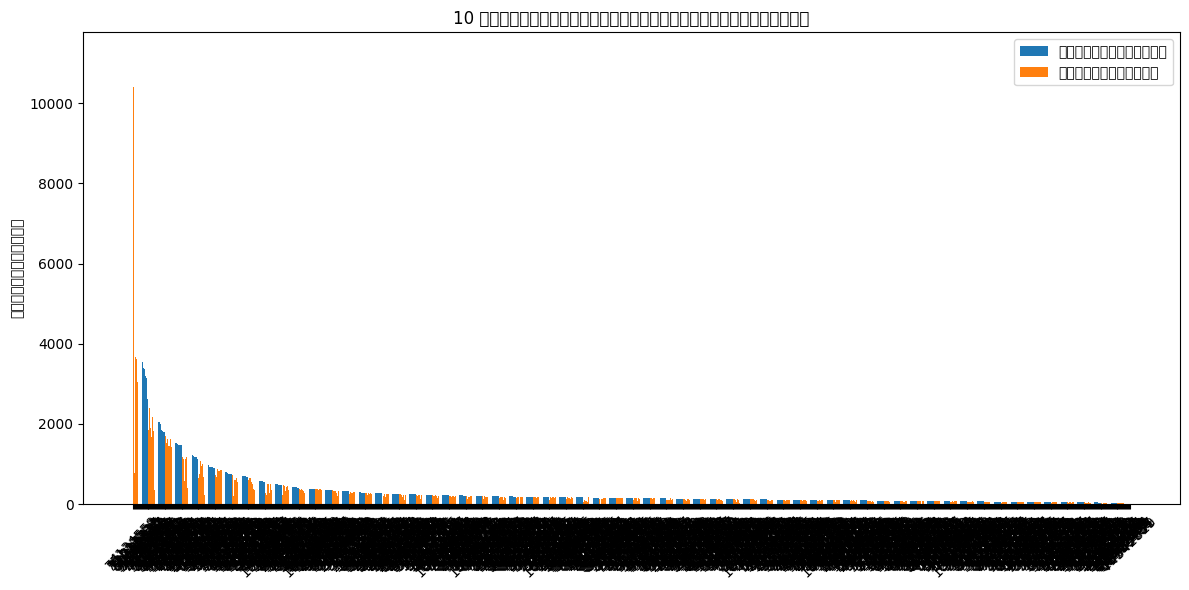

In [18]:
# กรองสินค้าที่ขายดีในช่วงโปรโมชั่น (ยอดขายเฉลี่ยสูงขึ้น)
top_promo_items = pivot[pivot['avg_sales_in_promo'] > pivot['avg_sales_no_promo']]
top_promo_items_sorted = top_promo_items.sort_values(by='avg_sales_in_promo', ascending=False)#.head(10)

# วาดกราฟเปรียบเทียบเฉพาะสินค้ากลุ่มนี้
plt.figure(figsize=(12, 6))
x = range(len(top_promo_items_sorted))
plt.bar(x, top_promo_items_sorted['avg_sales_in_promo'], width=0.4, label='ช่วงโปรโมชั่น', align='center')
plt.bar([i + 0.4 for i in x], top_promo_items_sorted['avg_sales_no_promo'], width=0.4, label='นอกโปรโมชั่น', align='center')
plt.xticks([i + 0.2 for i in x], top_promo_items_sorted['item_id'], rotation=45)
plt.ylabel("ยอดขายเฉลี่ย")
plt.title("10 สินค้าที่ขายดีขึ้นในช่วงโปรโมชั่น")
plt.legend()
plt.tight_layout()
plt.show()


สินค้าขายไม่ดี แต่ ขายดีตอนมีโปร

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1311492915.py:19: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1311492915.py:19: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1311492915.py:19: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1311492915.py:19: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1311492915.py:19: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\1311492915.py:19: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing f

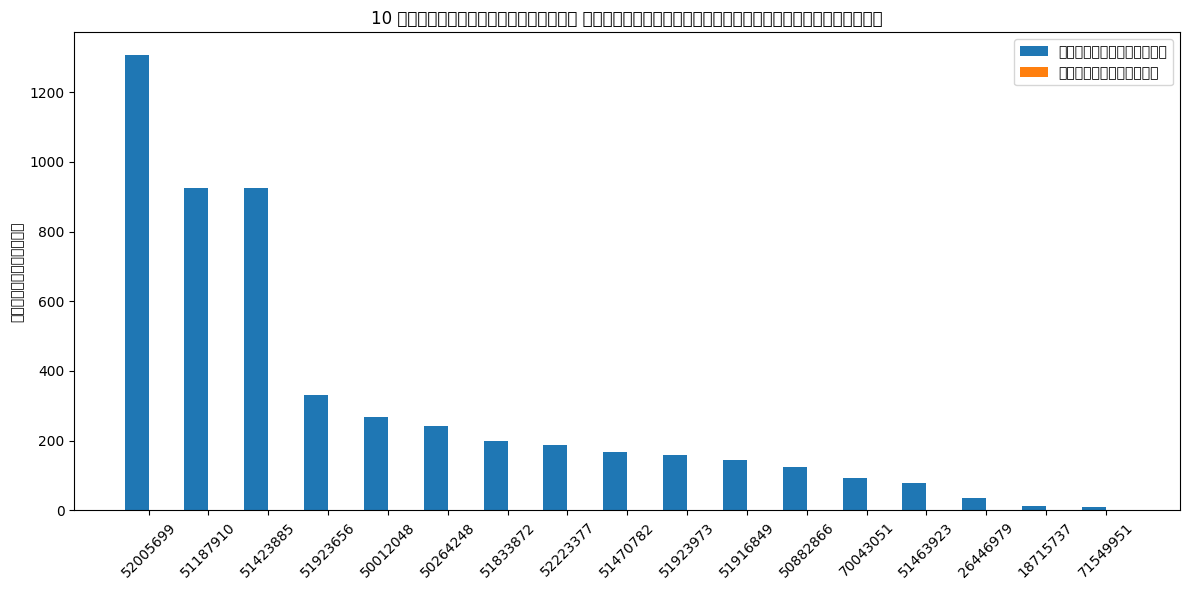

In [22]:
# เพิ่มคอลัมน์ส่วนต่างยอดขาย
pivot['sales_diff'] = pivot['avg_sales_in_promo'] - pivot['avg_sales_no_promo']

# กรองสินค้าที่ปกติขายไม่ออก (ยอดขายเฉลี่ย ≤ 10) และมียอดช่วงโปร > 10
interesting_items = pivot[(pivot['avg_sales_no_promo'] <= 10) & (pivot['avg_sales_in_promo'] > 10)]

# เรียงลำดับจากส่วนต่างยอดขายที่มากที่สุด
interesting_items_sorted = interesting_items.sort_values(by='sales_diff', ascending=False)#.head(10)

# วาดกราฟ
plt.figure(figsize=(12, 6))
x = range(len(interesting_items_sorted))
plt.bar(x, interesting_items_sorted['avg_sales_in_promo'], width=0.4, label='ช่วงโปรโมชั่น', align='center')
plt.bar([i + 0.4 for i in x], interesting_items_sorted['avg_sales_no_promo'], width=0.4, label='นอกโปรโมชั่น', align='center')
plt.xticks([i + 0.2 for i in x], interesting_items_sorted['item_id'], rotation=45)
plt.ylabel("ยอดขายเฉลี่ย")
plt.title("10 สินค้าที่ขายไม่ออก แต่มียอดขายสูงเมื่อมีโปรโมชั่น")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# โหลดข้อมูลชื่อสินค้า
hierarchy_df = pd.read_csv("item_hierarchy.csv")
hierarchy_df['item_id'] = hierarchy_df['item_id'].astype(str).str.strip()

# รวมชื่อสินค้าเข้ากับสินค้าขายดีตอนมีโปร
interesting_items_sorted['item_id'] = interesting_items_sorted['item_id'].astype(str)
named_items = interesting_items_sorted.merge(hierarchy_df, on='item_id', how='left')

# แสดงเฉพาะข้อมูลที่น่าสนใจ
named_items[['item_id', 'brand', 'category', 'subcategory', 'avg_sales_no_promo', 'avg_sales_in_promo', 'sales_diff']]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10380\85906602.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hierarchy_df = pd.read_csv("item_hierarchy.csv")


item_id          brand          category            subcategory  \
0   52005699       NO BRAND      10 : HARDL H         HOME FURNITURE   
1   51187910         LOTUSS      10 : HARDL H         HOME FURNITURE   
2   51423885         LOTUSS      10 : HARDL H         HOME FURNITURE   
3   51923656          PUREX  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
4   50012048        AMBIPUR  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
5   50264248         PIPPER  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
6   51833872          GLADE  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
7   52223377       NO BRAND      10 : HARDL H         HOME FURNITURE   
8   51470782          OASIS  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
9   51923973  HAKUGEN EARTH  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
10  51916849      KIENGMOOL  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
11  50882866         ATTACK  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
12  70043051       SAWASDEE  13 : DG NON FOOD               RELIGION   
13  51463923          D-NEE  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
14  26446979         LOTUSS    1 : FRESH FOOD                  FRUIT   
15  18715737      BABI MILD  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   
16  71549951         BREEZE  13 : DG NON FOOD  HOUSEHOLD CHEMICAL+GE   

    avg_sales_no_promo  avg_sales_in_promo   sales_diff  
0                  0.0         1306.540000  1306.540000  
1                  0.0          925.230000   925.230000  
2                  0.0          925.230000   925.230000  
3                  0.0          331.780000   331.780000  
4                  0.0          268.627143   268.627143  
5                  0.0          242.990000   242.990000  
6                  0.0          200.350000   200.350000  
7                  0.0          186.920000   186.920000  
8                  0.0          167.290000   167.290000  
9                  0.0          159.110000   159.110000  
10                 0.0          143.731667   143.731667  
11                 0.0          125.700000   125.700000  
12                 0.0           92.520000    92.520000  
13                 0.0           78.970769    78.970769  
14                 0.0           36.450000    36.450000  
15                 0.0           12.620000    12.620000  
16                 0.0           10.840000    10.840000